In [1]:
import gymnasium as gym
import numpy as np
import time
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from numpy.typing import ArrayLike

COLORS = mcolors.CSS4_COLORS

# GYMNASIUM FRAMEWORK : BlackJack

Let's explore a version of BlackJack where 
- there are two players only;
- the card dealer has a fixed policy.

An observation consists in a triple $(s, o, a) \in \{1\dots32\}\times \{1\dots11\} \times \{0, 1\}$ with :
- $s$ the value of our current hand 
- $o$ the value of our opponent's hand
- $a$ is $1$ if our player has a usable ace (can take value $1$ or $11$), $0$ otherwise 

The action space is $\{0 = stick, 1 = hit\}$.

The rewards are in $\{-1, 0, +1\}$.

## Basics of Gym.

In [2]:
# First make a new environment choising the desired game and a render_mode ('human' means there will be a pygame window displaying the game states, 'rgb_array' removes display)
env = gym.make('Blackjack-v1', render_mode = 'rgb_array')

# Before starting any episode, reset the env to create a new initial step
observation, info = env.reset()

## Fixed policies are inefficient!

In [3]:
# Create five probability distributions over {0, 1}:
# - 2 deterministic
# - 3 stochastic
probability_distributions = list(map(lambda tuple: np.array(tuple, dtype = np.float64), zip(np.arange(0, 1.01, step = .25), np.arange(1, -0.01, step = -.25))))


N_DISTRIBUTIONS = len(probability_distributions)
N_EPISODES = 10000
N_RUNS = 100

total_reward = np.zeros(shape = (N_DISTRIBUTIONS, N_RUNS, N_EPISODES), dtype = np.float64)

for index_distribution, distribution in tqdm(enumerate(probability_distributions)):
    for run in range(N_RUNS):
        for episode in range(N_EPISODES):
            
            observation, info = env.reset()
            current_sum, opponent_sum, available_ace = observation


            episode_over = False
            
            while not episode_over:
                action = env.action_space.sample(probability = distribution)

                observation, reward, terminated, truncated, info = env.step(action)
                
                current_sum, opponent_sum, available_ace = observation

                total_reward[index_distribution, run, episode] += reward
                episode_over = terminated

            episode += 1

env.close()

5it [04:06, 49.36s/it]


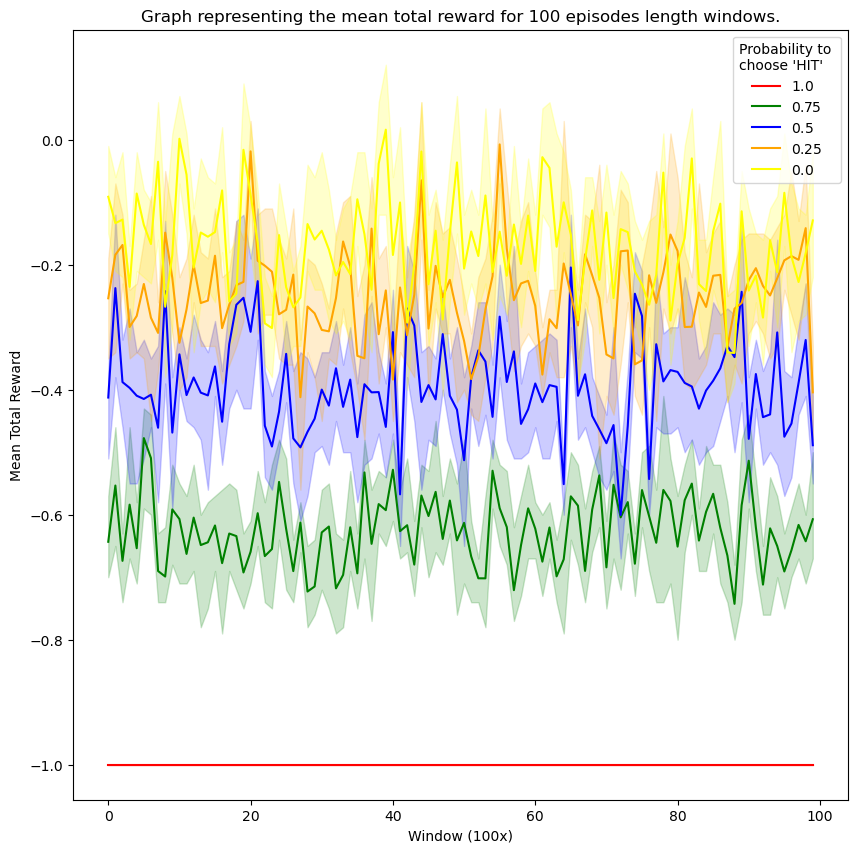

In [4]:
# Display the mean over the last 100 episodes
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

support = np.arange(0, N_EPISODES // 100)

colors = ["red", "green", "blue", "orange", "yellow"]
for index_distribution, distribution in enumerate(probability_distributions):
    current_color = colors[index_distribution]

    image = np.array([total_reward[index_distribution, :,i:i+100].mean(axis = 1) for i in support])

    y_min = image.min(axis = 0)
    y_max = image.max(axis = 0)

    ax.set_xlabel("Window (100x)")
    ax.set_ylabel("Mean Total Reward")
    ax.set_title("Graph representing the mean total reward for 100 episodes length windows.")

    ax.fill_between(support, y_min, y_max, alpha = .2, color = current_color)
    ax.plot(support, image.mean(axis = 0), label = f"${distribution[1]}$", color = current_color)

ax.legend(title = "Probability to \nchoose 'HIT'")

<u>Test conditions</u>:
- 100 runs of 10000 episodes.
- study of the mean total reward on 100 episode-long windows.

<u>Main takeways</u>: 
- Fixed policies are far from being efficient in the blakcjack context.
- It seems to be less risky to play 'STICK' than 'HIT'.

### NEXT STEP : HEURISTICAL APPROACH / CONTEXT-AWARE FIXED POLICIES

Here we will analyze the state space of the blackjack game. Remember our observations live in $\{1\dots32\}\times \{1\dots11\} \times \{0,1\} $.

#### Heuristic construction - Only with $s$

Let's build some rules for our player : 
1. if $s \le 11$, he should 'HIT', for any values of $o$.
2. if $s = 21$, he should 'STICK, for any values of $o$.
3. if $s \in \{12\dots20\}$, the choice is not fast-forward. Compute the probability that the player bust : 
    $1 - \frac{4 \cdot (21 - s)}{52} $.

The policy can be sum up as follows : 

$\mathbb{P}(1) = \begin{cases}
    1, \text{if } s \le 11 \\
    0, \text{if } s = 21 \\
    \frac{4 \cdot (21 - s)}{52}, \text{otherwise}\end{cases}$
    
$\mathbb{P}(0) = \begin{cases}
    0, \text{if } s \le 11 \\
    1, \text{if } s = 21 \\
    1 - \frac{4 \cdot (21 - s)}{52}, \text{otherwise}\end{cases}$

In [11]:
def policy(observation: tuple[int, int, int], action_space: gym.spaces.Discrete) -> int:
    s, o, a = observation

    if s <= 11:
        return 1

    elif s == 21:
        return 0
    
    else:
        p_hit = 4 * (21 - s) / 52
        distribution = np.array([p_hit, 1 - p_hit], dtype = np.float64)
        return action_space.sample(probability = distribution)

In [12]:
N_EPISODES = 10000
N_RUNS = 100

total_reward = np.zeros(shape = (N_RUNS, N_EPISODES), dtype = np.float64)

for run in range(N_RUNS):
    for episode in range(N_EPISODES):
        
        observation, info = env.reset()
        current_sum, opponent_sum, available_ace = observation


        episode_over = False
        
        while not episode_over:
            action = policy(observation = observation, action_space = env.action_space)

            observation, reward, terminated, truncated, info = env.step(action)
            
            current_sum, opponent_sum, available_ace = observation

            total_reward[run, episode] += reward
            episode_over = terminated

        episode += 1

env.close()

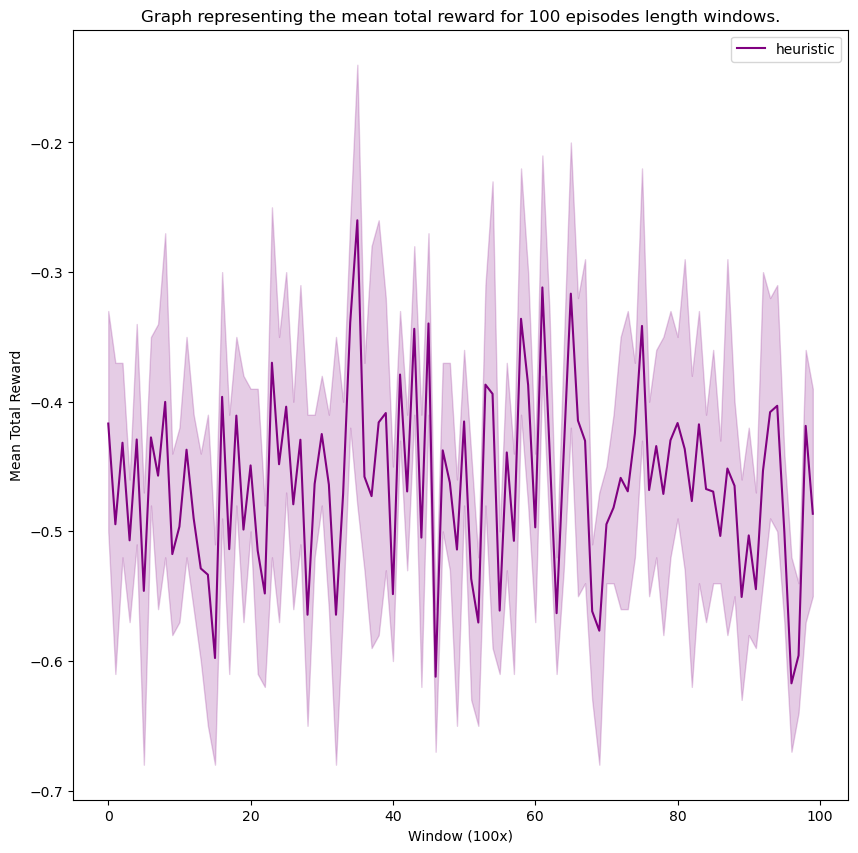

In [15]:
# Display the mean over the last 100 episodes
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

support = np.arange(0, N_EPISODES // 100)

color = "purple"

image = np.array([total_reward[:,i:i+100].mean(axis = 1) for i in support])

y_min = image.min(axis = 0)
y_max = image.max(axis = 0)

ax.set_xlabel("Window (100x)")
ax.set_ylabel("Mean Total Reward")
ax.set_title("Graph representing the mean total reward for 100 episodes length windows.")

ax.fill_between(support, y_min, y_max, alpha = .2, color = color)
ax.plot(support, image.mean(axis = 0), label = f"heuristic", color = color)

ax.legend()

<u>Test conditions</u>:
- 100 runs of 10000 episodes.
- study of the mean total reward on 100 episode-long windows.

<u>Main takeways</u>: 
- This policy is still bad as it only takes advantage of the player's current sum and not of the opponent one.
- A lot of variance in the rewards (big spikes).